In [1]:
!pip install traker[fast]
!pip install transformers
!pip install datasets
!pip install torch torchvision torchaudio

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for fast_jl: filename=fast_jl-0.1.3-cp310-cp310-linux_x86_64.whl size=971501 sha256=0d1a1a506a262497b97abbbda0841bed7fce8f54d96a36fedf6c55bcd081fcd5
  Stored in directory: /root/.cache/pip/wheels/c0/5e/37/3a9d828d49fbbcb9ba54a11d3b48a5a5ac627bd8beb46bf05b
  Created wheel for traker: filename=traker-0.3.2-py3-none-any.whl size=28986 sha256=9213e719cd2f433cdce15c3114579bff48c35273f39e0cc50fc8fffa7b119e8c
  Stored in directory: /root/.cache/pip/wheels/2a/bb/be/1e35e69a11e1aba84adfedeae2691798134199591cfe6d4f4e
Successfully built fast_jl traker
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
from argparse import ArgumentParser
from tqdm import tqdm
from pathlib import Path

import torch as ch
import torch.nn as nn
from torch.utils.data import DataLoader

from trak import TRAKer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Huggingface imports
from datasets import load_dataset
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    default_data_collator,
)
import pickle

In [3]:
# Configuration
GLUE_TASK_TO_KEYS = {
    "qnli": ("question", "sentence"),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}


# Adjust dataset size as needed for Colab
TRAIN_SET_SIZE = 50_000  # Reduced for Colab memory constraints
VAL_SET_SIZE = 5_463


class SequenceClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.config = AutoConfig.from_pretrained(
            "gchhablani/bert-base-cased-finetuned-qnli",
            num_labels=2,
            finetuning_task="qnli",
            attn_implementation="eager",
        )

        self.model = AutoModelForSequenceClassification.from_pretrained(
            "gchhablani/bert-base-cased-finetuned-qnli", config=self.config, ignore_mismatched_sizes=False
        )

        # Check if GPU is available
        self.device = "cuda" if ch.cuda.is_available() else "cpu"
        self.model.eval().to(self.device)

    def forward(self, input_ids, token_type_ids, attention_mask):
        return self.model(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
        ).logits


def get_dataset(split, inds=None):
    raw_datasets = load_dataset("glue", "qnli")
    sentence1_key, sentence2_key = GLUE_TASK_TO_KEYS["qnli"]

    tokenizer = AutoTokenizer.from_pretrained("gchhablani/bert-base-cased-finetuned-qnli", use_fast=True)

    def preprocess_function(examples):
        args = (examples[sentence1_key], examples[sentence2_key])
        return tokenizer(*args, padding="max_length", max_length=128, truncation=True)

    raw_datasets = raw_datasets.map(
        preprocess_function,
        batched=True,
        desc="Running tokenizer on dataset",
    )

    if split == "train":
        ds = raw_datasets["train"]
    else:
        ds = raw_datasets["validation"]
    return ds


def init_model(ckpt_path=None):
    model = SequenceClassificationModel()
    if ckpt_path and os.path.exists(ckpt_path):
        sd = ch.load(ckpt_path, map_location=model.device)
        model.model.load_state_dict(sd)
    return model


def init_loaders(batch_size=16):
    ds_train = get_dataset("train").select(range(TRAIN_SET_SIZE))
    ds_val = get_dataset("val").select(range(VAL_SET_SIZE))
    return (
        DataLoader(
            ds_train,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=default_data_collator,
        ),
        DataLoader(
            ds_val,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=default_data_collator,
        ),
    )


def process_batch(batch, device):
    return [
        x.to(device)
        for x in [
            batch["input_ids"],
            batch["token_type_ids"],
            batch["attention_mask"],
            batch["labels"],
        ]
    ]


def main():
    # Create output directory in Colab
    save_dir = Path("/content/trak_output")
    save_dir.mkdir(exist_ok=True)

    # Detect device
    device = "cuda" if ch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Initialize model and data loaders
    loader_train, loader_val = init_loaders()
    model = init_model()

    traker = TRAKer(
        model=model,
        task="text_classification",
        train_set_size=TRAIN_SET_SIZE,
        save_dir=save_dir,
        device=device,
        proj_dim=1024,
    )

    # Start TRAK analysis
    traker.load_checkpoint(model.state_dict(), model_id=0)

    print("Featurizing training data...")
    for batch in tqdm(loader_train):
        batch = process_batch(batch, device)
        traker.featurize(batch=batch, num_samples=batch[0].shape[0])

    traker.finalize_features()

    print("Scoring validation data...")
    traker.start_scoring_checkpoint(
        exp_name="qnli",
        checkpoint=model.state_dict(),
        model_id=0,
        num_targets=VAL_SET_SIZE,
    )

    for batch in tqdm(loader_val):
        batch = process_batch(batch, device)
        traker.score(batch=batch, num_samples=batch[0].shape[0])

    scores = traker.finalize_scores(exp_name="qnli")
    print("Analysis complete! Results saved to:", save_dir)
    return scores

In [4]:
scores = main()

Using device: cuda


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/872k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/877k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/104743 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5463 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5463 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Running tokenizer on dataset:   0%|          | 0/104743 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/5463 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/5463 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/5463 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/895 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

INFO:STORE:No existing model IDs in /content/trak_output.
INFO:STORE:No existing TRAK scores in /content/trak_output.


Featurizing training data...


  0%|          | 14/3125 [00:04<11:33,  4.49it/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Finalizing features for all model IDs..: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Scoring validation data...


Finalizing scores for all model IDs..: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]
INFO:STORE:Saving scores in /content/trak_output/scores/qnli.mmap


Analysis complete! Results saved to: /content/trak_output


In [5]:
def save_trak_scores(scores):
    # Load the raw text data
    raw_datasets = load_dataset("glue", "qnli")
    train_data = raw_datasets["train"]
    val_data = raw_datasets["validation"]

    data = {
        'val_index': [],
        'train_index': [],
        'train_label': [],
        'input': [],
        'score': [],
        'question': [],
        'sentence': []
    }

    for val_idx in range(VAL_SET_SIZE):
        # Get target example
        target = val_data[int(val_idx)]
        target_q = target["question"]
        target_s = target["sentence"]
        target_label = target["label"]

        # Get top 5 most influential training examples
        train_scores = scores[:TRAIN_SET_SIZE, val_idx]
        top_train_indices = torch.topk(torch.tensor(train_scores), k=5).indices
        bottom_train_indices = torch.topk(-torch.tensor(train_scores), k=5).indices

        train_indices = torch.cat([top_train_indices, bottom_train_indices])

        for i, train_idx in enumerate(train_indices, 1):
            train_example = train_data[int(train_idx)]
            score = train_scores[int(train_idx)]
            q = train_example["question"]
            s = train_example["sentence"]
            label = train_example["label"]

            data['val_index'].append(int(val_idx))
            data['train_index'].append(int(val_idx))
            data['train_label'].append(label)
            data['input'].append(f"{target_q}? {target_s}")
            data['score'].append(score)
            data['question'].append(q)
            data['sentence'].append(s)

    df = pd.DataFrame(data)
    df.to_csv('bert_trak_scores.csv', index=False)

    with open('bert_trak_scores.pkl', 'wb') as f:
        pickle.dump(scores, f)


if __name__ == "__main__":
    save_trak_scores(scores)

Visualizing TRAK scores and examples...

Target Example (Validation Index 5061):
Question: Where did Jebe die?
Sentence: Genghis Khan recalled Subutai back to Mongolia soon afterwards, and Jebe died on the road back to Samarkand.
Label: Not Entailment

Most Influential Training Examples:

1. Training Example (Index 13473, TRAK Score: 0.0720):
Question: When did Houston begin to regain its dependence on the oil industry?
Sentence: After the early 1990s recession, Houston made efforts to diversify its economy by focusing on aerospace and health care/biotechnology, and reduced its dependence on the petroleum industry.
Label: Entailment

2. Training Example (Index 29266, TRAK Score: 0.0702):
Question: What were all these tents and quilts for?
Sentence: The Sichuan Ministry of Civil Affairs said that they have provided 30,000 tents for those left homeless.
Label: Not Entailment

3. Training Example (Index 38637, TRAK Score: 0.0672):
Question: What other political hot issue did voters in Sea

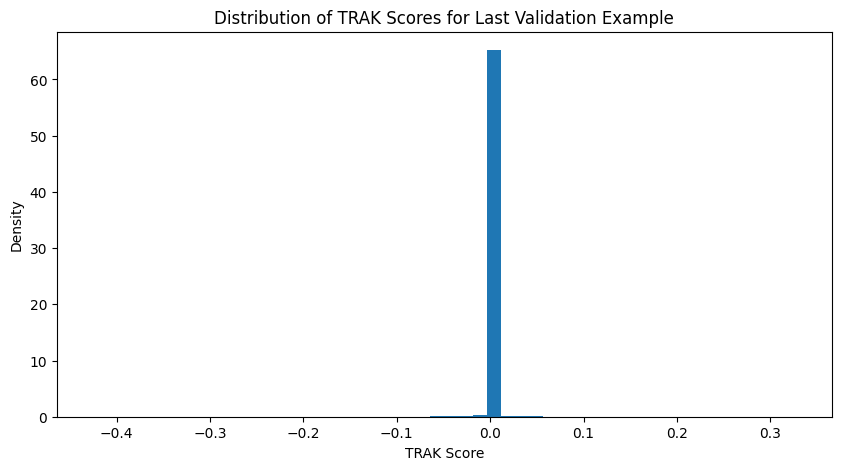

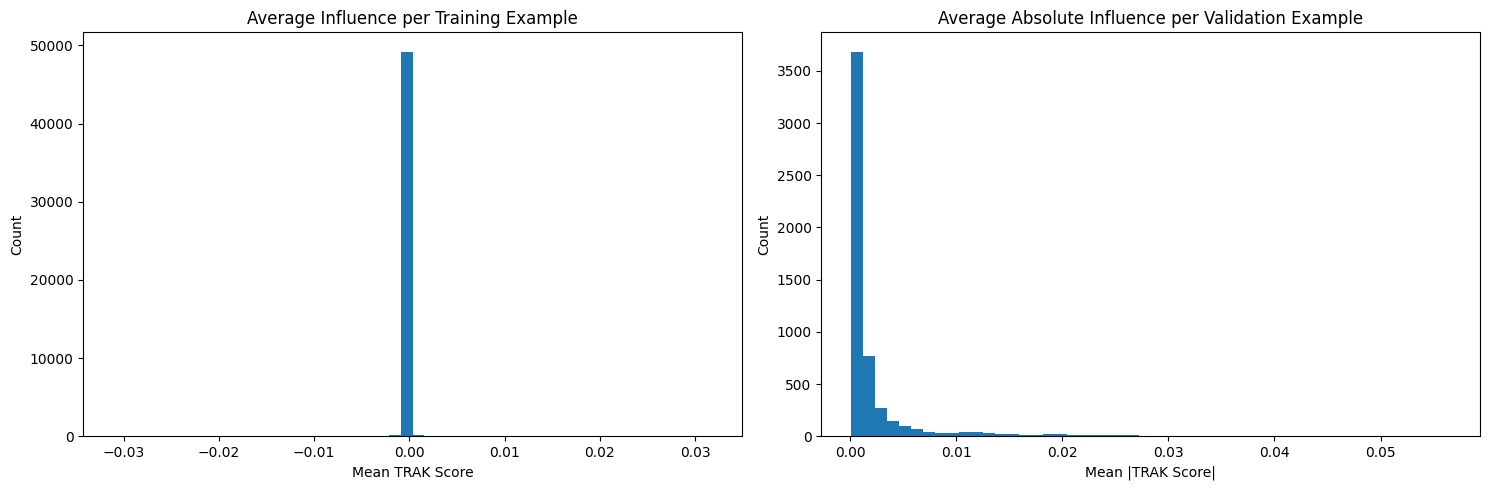

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch


def visualize_trak_examples(scores, n_examples=3):
    """
    Visualize examples with their most influential training examples according to TRAK scores
    """
    # Load the raw text data
    raw_datasets = load_dataset("glue", "qnli")
    train_data = raw_datasets["train"]
    val_data = raw_datasets["validation"]

    # Get random validation examples to visualize
    rng = np.random.RandomState(42)
    val_indices = rng.choice(VAL_SET_SIZE, n_examples, replace=False)

    for val_idx in val_indices:
        # Get target example
        target_example = val_data[int(val_idx)]
        target_q = target_example["question"]
        target_s = target_example["sentence"]
        target_label = (
            "Entailment" if target_example["label"] == 1 else "Not Entailment"
        )

        print("\n" + "=" * 80)
        print(f"Target Example (Validation Index {val_idx}):")
        print(f"Question: {target_q}")
        print(f"Sentence: {target_s}")
        print(f"Label: {target_label}")
        print("\nMost Influential Training Examples:")

        # Get top 5 most influential training examples
        train_scores = scores[:TRAIN_SET_SIZE, val_idx]
        top_train_indices = torch.topk(torch.tensor(train_scores), k=5).indices

        for i, train_idx in enumerate(top_train_indices, 1):
            train_example = train_data[int(train_idx)]
            score = train_scores[int(train_idx)]
            q = train_example["question"]
            s = train_example["sentence"]
            label = "Entailment" if train_example["label"] == 1 else "Not Entailment"

            print(
                f"\n{i}. Training Example (Index {train_idx}, TRAK Score: {score:.4f}):"
            )
            print(f"Question: {q}")
            print(f"Sentence: {s}")
            print(f"Label: {label}")

    # Plot score distribution for this validation example
    plt.figure(figsize=(10, 5))
    plt.hist(train_scores, bins=50, density=True)
    plt.title(f"Distribution of TRAK Scores for Last Validation Example")
    plt.xlabel("TRAK Score")
    plt.ylabel("Density")
    plt.show()

    # Plot overall statistics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Average influence per training example
    mean_influence = scores.mean(axis=1)
    ax1.hist(mean_influence, bins=50)
    ax1.set_title("Average Influence per Training Example")
    ax1.set_xlabel("Mean TRAK Score")
    ax1.set_ylabel("Count")

    # Average absolute influence per validation example
    mean_abs_influence = np.abs(scores).mean(axis=0)
    ax2.hist(mean_abs_influence, bins=50)
    ax2.set_title("Average Absolute Influence per Validation Example")
    ax2.set_xlabel("Mean |TRAK Score|")
    ax2.set_ylabel("Count")

    plt.tight_layout()
    plt.show()


# Call the visualization function with the TRAK scores
if __name__ == "__main__":
    print("Visualizing TRAK scores and examples...")
    visualize_trak_examples(scores)